In [1]:
import random
import os
from itertools import combinations
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr, spearmanr

In [2]:
repo_dir = "/Users/ameliachu/repos/nlu-reddit-toxicity-dataset"
data_dir = f"{repo_dir}/data"

In [3]:
labels = ['toxicity', 'severe_toxicity', 'identity_attack', 'insult', 'profanity', 'threat']

In [4]:
labelled_data_file_name = "labelled_master_data_2022-05-11.csv"
labelled_data_location = f"{data_dir}/{labelled_data_file_name}"

In [5]:
figures = {}
tables = {}

In [6]:
labelled_data = pd.read_csv(labelled_data_location)

In [7]:
labelled_data.head(5)

,Unnamed: 0,example_id,preceding_comment,comment_for_evaluation,following_comment,toxicity,severe_toxicity,identity_attack,insult,profanity,threat
0,6,275362,Which one of u bought my stocks? >:(,posted this in the other thread but the more i...,That thing is 1.64% rn. JPow has to say somet...,0.0,0.0,0.0,0.0,1.0,0.0
1,12,30108,Alexa play down by 311.,No one cares about 10 year bonds bro - thats j...,Sorry you were born the bad kind of retarded.,0.0,0.0,0.0,0.0,1.0,0.0
2,21,316461,Today = no Vaseline,The entire market is fucking hemorrhaging,Imagine putting your money in bonds lol,0.0,0.0,0.0,0.0,1.0,0.0
3,22,316957,definitely. keep buying guys !!!!! HURRRDURRr,damn so my puts are fukd,"Quick, everyone buy Into the bull trap again!",0.0,0.0,0.0,0.0,1.0,0.0
4,23,318752,Big if true.,Do you routinely comment your opinion on topic...,"They get all 4, fuck that.\n\nJust one Warlock...",1.0,1.0,0.0,1.0,0.0,0.0


In [8]:
# Make the words look nicer
labels_dict = {
     'toxicity': 'Toxicity',
     'severe_toxicity': 'Severe Toxicity',
     'identity_attack': 'Identity Attack',
     'insult': 'Insult',
     'profanity': 'Profanity',
     'threat':'Threat'
}

In [9]:
labelled_data = labelled_data.rename(columns=labels_dict)

In [19]:
labels = list(labels_dict.values())

In [20]:
n_total_examples = labelled_data.count()[0]
print(n_total_examples)

800


In [21]:
examples_with_missing_labels = labelled_data[labelled_data.isna().any(axis=1)]['example_id']
print(len(examples_with_missing_labels))

0


In [23]:
labelled_data['has_toxicity'] = labelled_data[labels].sum(axis=1)
n_toxic_examples =  labelled_data[labelled_data['has_toxicity'] >=1].count()[0]
total_examples = labelled_data.count()[0]
f"{n_toxic_examples} {n_toxic_examples / total_examples:.2f}"

'483 0.60'

In [ ]:
all_reviewed_distribution = pd.concat

In [26]:
overall_count = pd.DataFrame([{'data_label': 'Overall',
               'number_of_examples': labelled_data.count()[0]}])
by_label_count = labelled_data.agg({l:sum for l in labels}).reset_index()
by_label_count.columns = ["Attribute", "Number of Examples"]

tables['label_distribution'] = pd.concat([overall_count,by_label_count ]).reset_index(drop=True)

In [31]:
tables['label_distribution'].columns = ["Attribute", "Number of Examples"]

In [34]:
f"{repo_dir}/reporting/assets/data-distribution.csv"

'/Users/ameliachu/repos/nlu-reddit-toxicity-dataset/reporting/assets/data-distribution.csv'

In [38]:
tables['label_distribution'].to_csv(f"{repo_dir}/reporting/assets/data-distribution.csv",index=False)

In [49]:
tables['label_distribution']

,Attribute,Number of Examples
0,Overall,800.0
1,Toxicity,109.0
2,Severe Toxicity,24.0
3,Identity Attack,67.0
4,Insult,130.0
5,Profanity,405.0
6,Threat,3.0


In [46]:
all_labelled_data_file_name = "all_labelled_data_2022-05-12.csv"
all_labelled_data_location = f"{data_dir}/{all_labelled_data_file_name}"
all_reviewed_distribution = pd.read_csv(all_labelled_data_location)

all_reviewed_distribution  = all_reviewed_distribution .rename(columns=labels_dict)

In [47]:
overall_count = pd.DataFrame([{"Attribute": 'Overall',
               "Number of Examples": all_reviewed_distribution.count()[0]}])
by_label_count = all_reviewed_distribution.agg({l:sum for l in labels}).reset_index()
by_label_count.columns = ["Attribute", "Number of Examples"]
tables['all_reviewed_distribution'] = pd.concat([overall_count,by_label_count ]).reset_index(drop=True)
tables['all_reviewed_distribution'].to_csv(f"{repo_dir}/reporting/assets/data-distribution-all-reviewed.csv",index=False)

In [48]:
tables['all_reviewed_distribution'] 

,Attribute,Number of Examples
0,Overall,2441.0
1,Toxicity,109.0
2,Severe Toxicity,24.0
3,Identity Attack,67.0
4,Insult,130.0
5,Profanity,405.0
6,Threat,3.0


In [28]:
tables['label_corr'] = labelled_data[labels].corr('pearson')

In [29]:
tables['label_corr'] 

,Toxicity,Severe Toxicity,Identity Attack,Insult,Profanity,Threat
Toxicity,1.000000,0.442793,0.313996,0.625096,0.056983,0.035247
Severe Toxicity,0.442793,1.000000,0.184902,0.339657,0.100396,-0.010790
Identity Attack,0.313996,0.184902,1.000000,0.331636,0.054887,-0.018549
Insult,0.625096,0.339657,0.331636,1.000000,0.096153,0.083847
Profanity,0.056983,0.100396,0.054887,0.096153,1.000000,-0.021219
Threat,0.035247,-0.010790,-0.018549,0.083847,-0.021219,1.000000


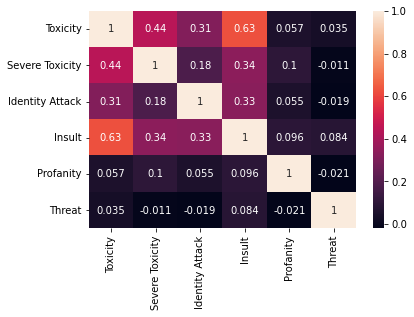

In [30]:
figures['label_corr'] = sns.heatmap(tables['label_corr'], annot=True)
figures['label_corr']

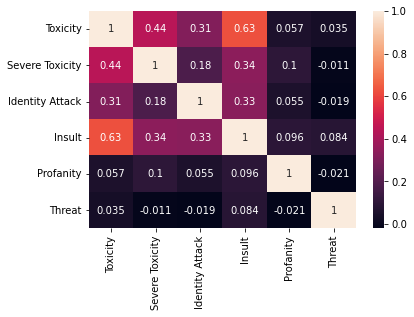

In [37]:
from matplotlib import pyplot as plt
sns.heatmap(tables['label_corr'], annot=True)
plt.savefig(f'{repo_dir}/reporting/assets/heatmap-corr.png')

In [20]:
interrater_dir = f"{data_dir}/interrater-reliability"

In [21]:
interrater_files = [f for f in os.listdir(interrater_dir) if f.startswith('interrater2') ]

In [20]:
interrater_info = {}
for file in interrater_files:
    file_type, rater_id, date_rated = file.split('.')[0].split('-')
    data_path = f'{interrater_dir}/{file}'
    interrater_info[rater_id] = {
        "data": pd.read_csv(data_path),
        "created_date": date_rated,
        "file_path": data_path
                          }

In [21]:
raters = list(interrater_info.keys())
random.shuffle(raters)

In [22]:
num_raters = len(raters)
all_rater_combinations = list(combinations(range(num_raters), 2))

In [23]:
interrater_assessments = []
labels = ['toxicity', 'severe_toxicity', 'identity_attack', 'insult', 'profanity', 'threat']
selected_columns = ['example_index','comment_for_evaluation'] + labels

for i, rater_id in enumerate(raters):
    individual_ratings = interrater_info[rater_id]['data'][selected_columns]
    interrater_assessment = pd.melt(individual_ratings,
                                    id_vars=['example_index'], 
                                    value_vars=labels)\
                              .rename(columns={'value':'label'})
    # Using file id instead of rater_id to anonymize results
    interrater_assessment["file_id"] = i
    interrater_assessments.append(interrater_assessment)

In [24]:
interrater_assessments_df = pd.concat(interrater_assessments)
interrater_assessments_df = pd.pivot(interrater_assessments_df, 
                                     index=['variable', 'example_index'], 
                                     columns='file_id', values='label').fillna(0).reset_index()

In [25]:
spearmanr_reliability = []
for rater_x, rater_y in all_rater_combinations:
    r_coef, p_value = spearmanr(interrater_assessments_df[rater_x].values, interrater_assessments_df[rater_y].values)
    data = {"rater_pair": (rater_x, rater_y), "r_coef": r_coef, "p_value": p_value, "spearmanr_reliability_type":"overall"}
    spearmanr_reliability.append(data)

    for variable in interrater_assessments_df['variable'].unique():
        rater_x_values = interrater_assessments_df[interrater_assessments_df['variable']==variable][rater_x].values
        rater_y_values = interrater_assessments_df[interrater_assessments_df['variable']==variable][rater_y].values
        var_r_coef, var_p_value = spearmanr(rater_x_values, rater_y_values)
        data = {"rater_pair": (rater_x, rater_y), "r_coef": var_r_coef, "p_value": var_p_value, 
                "spearmanr_reliability_type":f"by_var_{variable}"}
        spearmanr_reliability.append(data)

/Users/ameliachu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [26]:
spearmanr_reliability_df = pd.DataFrame(spearmanr_reliability)[['spearmanr_reliability_type', 'rater_pair', 'r_coef','p_value']].fillna(1)

In [27]:
spearmanr_reliability_df.groupby('spearmanr_reliability_type').agg({'r_coef':np.mean}).reset_index()

,spearmanr_reliability_type,r_coef
0,by_var_identity_attack,0.800000
1,by_var_insult,0.853553
2,by_var_profanity,0.800000
3,by_var_severe_toxicity,0.938743
4,by_var_threat,1.000000
5,by_var_toxicity,0.500000
6,overall,0.710046


In [ ]:
Label Type Interrater Reliability (Spearmann)